# Importing Packages

In [1]:
# %pip install 'tensorflow[and-cuda]'
# %pip install transformers
# %pip install tf-keras
# %pip install tensorflow-hub

In [31]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow_hub as hub
from tqdm import tqdm
import numpy as np
from PIL import Image
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
# model = TFAutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

In [3]:
!nvidia-smi

Fri Jan 31 01:10:06 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   23C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17563196399921229712
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4235889980484030626
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
xla_global_id: 416903419
]


I0000 00:00:1738285807.012753    1340 gpu_device.cc:2022] Created device /device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Ingestion

In [11]:
# !unzip ./final_dataset_2.zip -d ./final_dataset_2
# !unzip ./val_images.zip -d ./val_images

In [12]:
df = pd.read_csv('./final_dataset.csv')
df.head()

,image_path,label,meme_text,file_extension,language_code,sentence_length,average_word_length,hashtags_count,emails_count,numbers_count,usernames_count,websites,pos_tags,named_entities,new_image_path,meme_text_masked
0,./dataset/violence against women meme offensiv...,1,When mom takes away my fidget spinner.,jpg,Language.ENGLISH,7,4.571429,0,0,0,0,[],"['SCONJ', 'NOUN', 'VERB', 'ADV', 'PRON', 'NOUN...",[],final_dataset/Image_15_0d42f67a-74dd-4415-b286...,When mom takes away my fidget spinner.
1,./dataset/violence against women meme offensiv...,1,Morning wood? You mean my wife's alarm clock.,jpg,Language.ENGLISH,8,4.750000,0,0,0,0,[],"['NOUN', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'PRO...",[],final_dataset/Image_14_255b3022-61df-4e4e-93d0...,Morning wood? You mean my wife's alarm clock.
2,./dataset/violence against women meme offensiv...,1,When captain man calls you to the man cave at ...,jpg,Language.ENGLISH,23,3.956522,0,0,0,0,[],"['SCONJ', 'NOUN', 'NOUN', 'VERB', 'PRON', 'ADP...",['TIME'],final_dataset/Image_16_fa940fca-ef00-4425-851e...,When captain man calls you to the man cave at ...
3,./dataset/violence against women meme offensiv...,1,KILL ALL JEWISHS.,jpg,Language.ENGLISH,3,5.000000,0,0,0,0,[],"['VERB', 'DET', 'PROPN', 'PUNCT']",['ORG'],final_dataset/Image_17_bb0e97ae-e051-4482-a394...,KILL ALL JEWISHS.
4,./dataset/violence against women meme offensiv...,1,The violence has escalated.,png,Language.ENGLISH,4,6.000000,0,0,0,0,[],"['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']",[],final_dataset/Image_13_b5413513-2d35-4269-bf4f...,The violence has escalated.


3it [00:00, 15.83it/s]


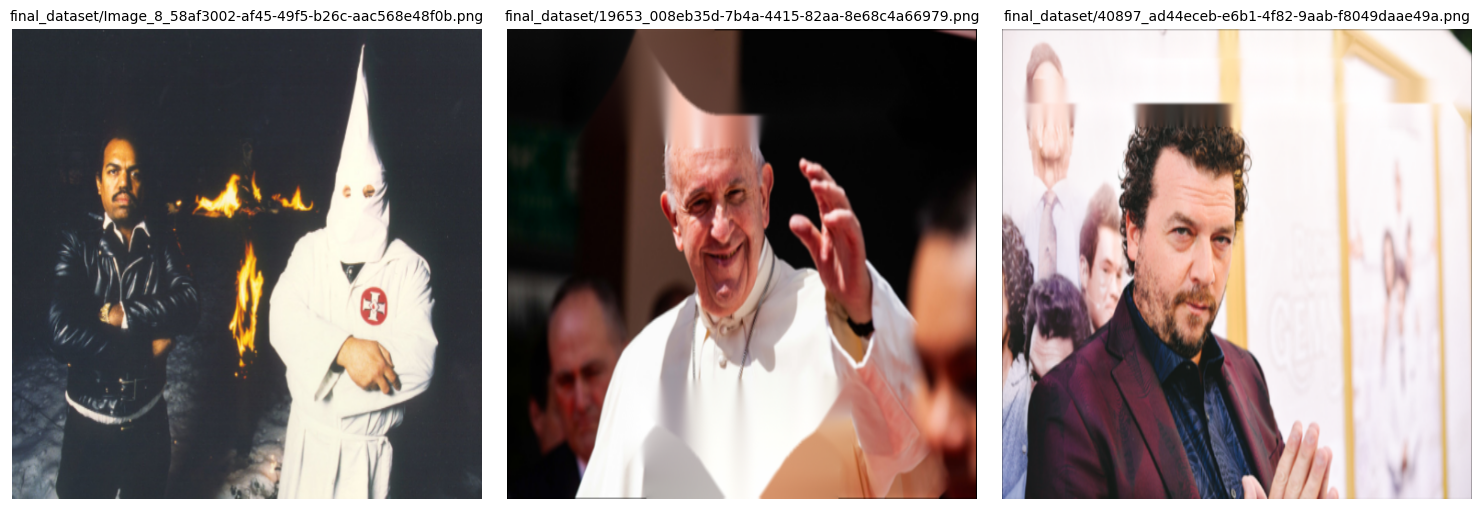

In [13]:
def display_random_images(df, image_column):
    sampled_rows = df.sample(n=3)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, (_, row) in tqdm(zip(axes, sampled_rows.iterrows())):
        try:
            image_path = row[image_column].replace("final_dataset/", "final_dataset_2/final_dataset/")
            image_path = f"{image_path}"
            
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')  # Turn off axis
            
            ax.set_title(row[image_column], fontsize=10)
        except Exception as e:
            ax.set_title("Error loading image", fontsize=10)
            ax.axis('off')
            print(f"Error loading image: {e}")
    
    plt.tight_layout()
    plt.show()

display_random_images(df, "new_image_path")

# Generating Feature Embeddings

In [39]:
train_df = df[["new_image_path", "meme_text_masked", "label"]]
train_df.head()

,new_image_path,meme_text_masked,label
0,./final_dataset/Image_15_0d42f67a-74dd-4415-b2...,When mom takes away my fidget spinner.,1
1,./final_dataset/Image_14_255b3022-61df-4e4e-93...,Morning wood? You mean my wife's alarm clock.,1
2,./final_dataset/Image_16_fa940fca-ef00-4425-85...,When captain man calls you to the man cave at ...,1
3,./final_dataset/Image_17_bb0e97ae-e051-4482-a3...,KILL ALL JEWISHS.,1
4,./final_dataset/Image_13_b5413513-2d35-4269-bf...,The violence has escalated.,1


In [40]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print("Training set:")
print("Training shape:", train_df.shape)
display(train_df.head())

print("Validation set:")
print("Validation shape:", val_df.shape)
display(val_df.head())

Training set:
Training shape: (7804, 3)


,new_image_path,meme_text_masked,label
3279,./final_dataset/48739_d7438f91-68d3-4192-b4d5-...,happy birthday the mexicans will pay for your ...,1
6911,./final_dataset/08423_e2805d4d-8d74-4d19-b38c-...,true love is an emotion,0
4641,./final_dataset/46735_d4bb86a6-1fe1-432c-bfd5-...,old ugly mexican granny wanna be light skinned...,1
6448,./final_dataset/29150_22a0864e-c2b0-404c-abae-...,"back in my day, you were either america first ...",0
6179,./final_dataset/67352_26e87fe0-396f-40d5-8635-...,play stupid games win stupid prizes,0


Validation set:
Validation shape: (1951, 3)


,new_image_path,meme_text_masked,label
4537,./final_dataset/49351_87c34c08-ec93-4bbb-bbaa-...,when you've been released from fb jail knowing...,0
4694,./final_dataset/07924_90f487b0-f273-4d44-9568-...,when you've accepted your sexual preferences a...,0
1606,./final_dataset/34791_06fb6e98-515b-4f67-9e4a-...,when i was a boy we didn't have things like ad...,1
9572,./final_dataset/01548_069fa019-9041-4103-b7a1-...,what are they fighting over? is it: a) the las...,0
3540,./final_dataset/45930_f6a6ca77-fb40-43e9-b1d2-...,if you got your phone wet try leaving it in dr...,0


## Finetuning Bert for Text Classification

In [54]:
# bert finetuning
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

train_texts, train_labels = train_df["meme_text_masked"].tolist(), train_df["label"].tolist()
val_texts, val_labels = val_df["meme_text_masked"].tolist(), val_df["label"].tolist()

In [55]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

In [59]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(train_labels)))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/30
488/488 [==============================] - 112s 197ms/step - loss: 0.6976 - accuracy: 0.5296 - val_loss: 0.6914 - val_accuracy: 0.5320
Epoch 2/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6902 - accuracy: 0.5428 - val_loss: 0.6911 - val_accuracy: 0.5320
Epoch 3/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6903 - accuracy: 0.5446 - val_loss: 0.6912 - val_accuracy: 0.5320
Epoch 4/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6900 - accuracy: 0.5415 - val_loss: 0.6914 - val_accuracy: 0.5320
Epoch 5/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6900 - accuracy: 0.5420 - val_loss: 0.6913 - val_accuracy: 0.5320
Epoch 6/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6915 - val_accuracy: 0.5320
Epoch 7/30
488/488 [==============================] - 94s 192ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6915 - val_a

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict()

## Finetuning ViT for Image Classification

## Bert and ViT (early fusion)

## Bert and ViT (Late fusion)

## CLIP based approach (early fusion)

In [30]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = TFCLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [15]:
df['meme_text_masked'] = df['meme_text_masked'].fillna("").astype(str)
df['new_image_path'] = df['new_image_path'].apply(lambda x: f"./{x}" if not x.startswith("./") else x)
df['meme_text_masked'] = df['meme_text_masked'].replace("", "No text provided")

In [16]:
from tensorflow.keras.layers import Dense, Lambda

def get_clip_embeddings_with_adapters(image_paths, texts, batch_size=32, embedding_dim=1024, alpha=0.5):
    image_embeds = []
    text_embeds = []

    # Iterate through batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing Batches"):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_texts = texts[i:i + batch_size]

        try:
            # Load images
            images = [Image.open(p).convert("RGB") for p in batch_image_paths]
        except Exception as e:
            print(f"Error loading images in batch {i // batch_size + 1}. Example image paths: {batch_image_paths}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error loading images

        try:
            # Get CLIP model embeddings
            inputs = clip_processor(text=batch_texts, images=images, return_tensors="tf", padding=True)
            outputs = clip_model(**inputs)

            image_embeds.append(outputs.image_embeds.numpy())
            text_embeds.append(outputs.text_embeds.numpy())
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}. Example texts: {batch_texts}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error processing text and images

    # Concatenate all batches
    if image_embeds and text_embeds:
        image_embeds = np.concatenate(image_embeds, axis=0)
        text_embeds = np.concatenate(text_embeds, axis=0)

        # Define linear projection layers
        image_proj_layer = Dense(embedding_dim, name="image_projection")
        text_proj_layer = Dense(embedding_dim, name="text_projection")

        # Apply projection
        F_proj_I = image_proj_layer(image_embeds)
        F_proj_T = text_proj_layer(text_embeds)

        # Define feature adapters
        image_adapter = Dense(embedding_dim, activation='relu', name="image_adapter")
        text_adapter = Dense(embedding_dim, activation='relu', name="text_adapter")

        # Apply adapters
        A_I = image_adapter(F_proj_I)
        A_T = text_adapter(F_proj_T)

        # Compute final representations with residual connections
        F_I = alpha * A_I + (1 - alpha) * F_proj_I
        F_T = alpha * A_T + (1 - alpha) * F_proj_T

        return F_I.numpy(), F_T.numpy()
    else:
        print("No valid embeddings generated.")
        return np.array([]), np.array([])

# Call the updated function
image_embeds, text_embeds = get_clip_embeddings_with_adapters(
    df['new_image_path'].tolist(), 
    df['meme_text_masked'].tolist(),
    embedding_dim=1024, 
    alpha=0.5
)

Processing Batches:   0%|          | 0/305 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (117 > 77). Running this sequence through the model will result in indexing errors
I0000 00:00:1738285948.191408    1340 cuda_dnn.cc:529] Loaded cuDNN version 90300
Processing Batches: 100%|██████████| 305/305 [06:46<00:00,  1.33s/it]


In [17]:
labels = df['label'].values
num_classes = len(np.unique(labels))
num_classes

2

In [18]:
# modality fusion

fused_embeds = image_embeds * text_embeds 
fused_embeds

array([[-8.90849515e-06,  2.03028700e-04,  8.86463386e-05, ...,
        -4.28538897e-07, -1.82010442e-08,  2.58030445e-06],
       [-5.31601972e-06, -3.22909582e-05,  9.06428613e-05, ...,
         9.33934876e-04,  2.26421704e-04,  9.17579018e-05],
       [ 1.95314671e-04,  2.51725782e-04,  2.52028694e-05, ...,
        -1.92336054e-04,  1.56633309e-04,  7.05290076e-05],
       ...,
       [ 1.01232436e-04, -4.55394729e-05, -5.31090991e-05, ...,
         1.33237554e-04,  4.68893595e-05,  4.69436112e-04],
       [ 3.14901321e-04,  2.43006769e-04,  9.12672476e-05, ...,
        -3.32287573e-06,  1.76879475e-05,  9.96124727e-05],
       [ 2.61055775e-05,  1.86592806e-04, -1.55757123e-04, ...,
         2.18922243e-04, -2.27520402e-04,  2.55884224e-05]], dtype=float32)

In [19]:
fused_embeds.shape

(9755, 1024)

In [24]:
def build_classification_model_with_residual(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    # First block with residual connection
    x = layers.Dense(1024, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(inputs)  # L2 regularization
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual1 = layers.Dense(1024, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual1 = layers.BatchNormalization()(residual1)  # Batch Normalization
    x = layers.Add()([x, residual1])
    
    # Second block with residual connection
    x = layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual2 = layers.Dense(512, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual2 = layers.BatchNormalization()(residual2)  # Batch Normalization
    x = layers.Add()([x, residual2])
    
    # Third block with residual connection
    x = layers.Dense(256, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual3 = layers.Dense(256, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual3 = layers.BatchNormalization()(residual3)  # Batch Normalization
    x = layers.Add()([x, residual3])
    
    # Fourth block without residuals for bottleneck
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Dropout for regularization

    # Output layer: classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = build_classification_model_with_residual(input_dim, num_classes=num_classes)
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classification_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1024)      │  1,049,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1024)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    524,800 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │    262,656 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 512)       │          0 │ dropout_5[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dropout_6[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ add_5[0][0]     

 Total params: 3,131,649 (11.95 MB)

 Trainable params: 3,124,225 (11.92 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [25]:
# Create a stratified split
fused_embeds_train, fused_embeds_val, labels_train, labels_val = train_test_split(
    fused_embeds, labels, 
    test_size=0.2,        # 20% for validation
    stratify=labels,      # Ensures equal label distribution
    random_state=42       # For reproducibility
)

# Define optimizer
optimizer = AdamW(learning_rate=1e-4)

# Compile the model
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with early stopping
history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=50,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5126 - loss: 40.2081 - val_accuracy: 0.4577 - val_loss: 37.0997
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5396 - loss: 36.4078 - val_accuracy: 0.4577 - val_loss: 33.5854
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5640 - loss: 32.9378 - val_accuracy: 0.6263 - val_loss: 30.4373
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5783 - loss: 29.9144 - val_accuracy: 0.6586 - val_loss: 27.6863
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5810 - loss: 27.2723 - val_accuracy: 0.6715 - val_loss: 25.2646
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6121 - loss: 24.8654 - val_accuracy: 0.6791 - val_loss: 23.0926
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6297 - loss: 22.7077 - val_accuracy: 0.6694 - val_loss: 21.1209
Epoch 8/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6418 - loss: 20.7698 -

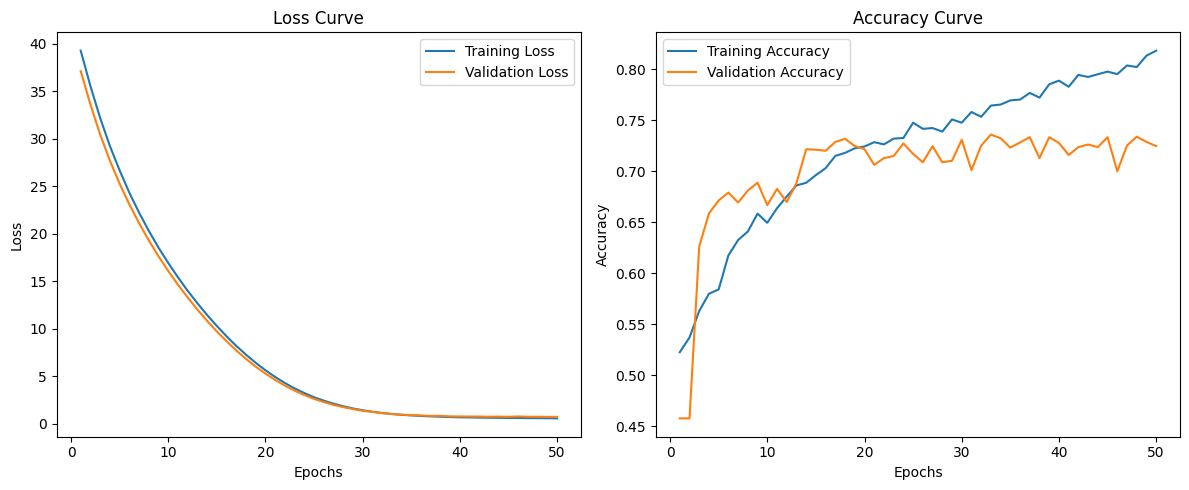

In [26]:
def plot_training_curves(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot curves
plot_training_curves(history)

## Model Performance Evaluation

## Testing against adverserial attacks

## Explainability

# Exporting Best Model

In [19]:
# classification_model.save('classification_model.h5') 

converter = tf.lite.TFLiteConverter.from_keras_model(classification_model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


Saved artifact at '/tmp/tmpgxpalmmu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140283672841904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140289157982944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680365856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680358464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680362336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680360400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680373424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680370256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283672667312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140285858787952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140284036858800: Tens

W0000 00:00:1737432219.200128    1680 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737432219.200152    1680 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 04:03:39.200979: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.203100: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 04:03:39.203122: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpgxpalmmu
I0000 00:00:1737432219.223305    1680 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-21 04:03:39.228662: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 04:03:39.403179: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.445861: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [20]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='best_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
